In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
import pretrainedmodels
sys.path.append('../')
from fastai.vision import *
from modules.basics import *
np.random.seed(0)

# Data import

In [2]:
path = IMG_PATH/'pixel_squares_images'

In [3]:
train_df = pd.read_csv(IMG_PATH/'train.csv'); len(train_df); train_df.head()

,image_name,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_lep_pz,PRI_jet_leading_px,PRI_jet_leading_py,PRI_jet_leading_pz,PRI_met_px,PRI_met_py,PRI_met_pt,PRI_jet_num,gen_target,gen_weight
0,0,0,235,130,90,0,0,0,168,128,...,143,0,0,0,54,156,155,0,0,0.000072
1,1,98,79,99,100,0,0,0,170,94,...,109,151,140,133,142,162,87,85,0,0.000051
2,2,143,87,161,77,0,0,0,181,88,...,203,0,0,0,132,100,79,0,1,0.000346
3,3,151,58,140,167,233,242,16,165,82,...,138,96,199,249,201,115,166,170,1,0.000028
4,4,126,105,134,131,0,0,0,143,79,...,75,139,105,104,121,177,91,85,0,0.000079


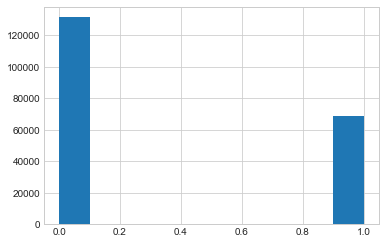

In [4]:
train_df.gen_target.hist()

In [5]:
len(train_df[train_df.gen_target==0])/len(train_df), len(train_df[train_df.gen_target==1])/len(train_df)

(0.65733, 0.34267)

In [28]:
size = 56

In [6]:
data = ImageDataBunch.from_df(df=train_df, label_col='gen_target', fn_col='image_name',
                              bs=512, ds_tfms=None, num_workers=8, valid_pct=0.2,
                              path=path, folder='train', suffix='.png').normalize(imagenet_stats)

In [7]:
data

ImageDataBunch;

Train: LabelList (160000 items)
x: ImageList
Image (3, 56, 56),Image (3, 56, 56),Image (3, 56, 56),Image (3, 56, 56),Image (3, 56, 56)
y: CategoryList
0,0,1,1,0
Path: /home/giles/Documents/kaggle/higgsml/pixel_squares_images;

Valid: LabelList (40000 items)
x: ImageList
Image (3, 56, 56),Image (3, 56, 56),Image (3, 56, 56),Image (3, 56, 56),Image (3, 56, 56)
y: CategoryList
1,1,1,0,1
Path: /home/giles/Documents/kaggle/higgsml/pixel_squares_images;

Test: None

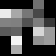

In [21]:
data.train_ds[0][0]

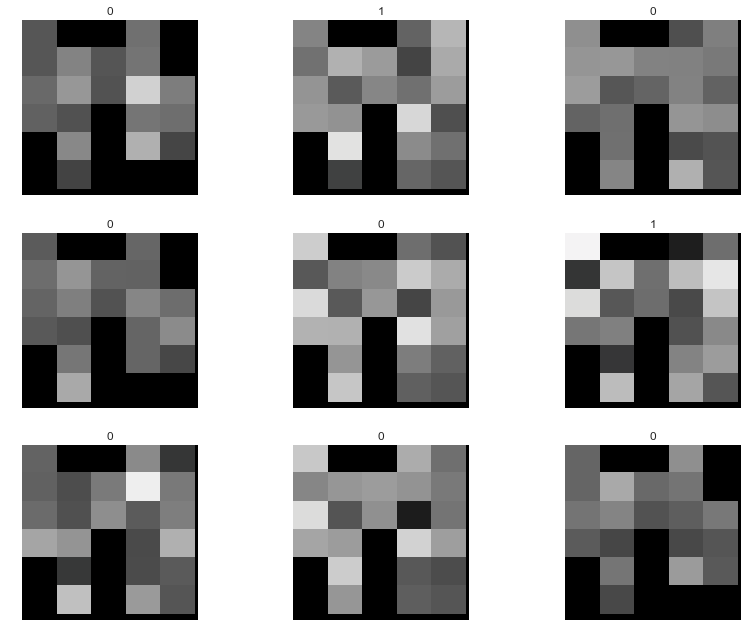

In [22]:
data.show_batch(rows=3, figsize=(12,9))

# Model training

In [8]:
def se_resnet50(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.se_resnet50(pretrained=pretrained)
    return model

In [9]:
learn = cnn_learner(data, se_resnet50, pretrained=True, cut=-2, split_on=lambda m: (m[0][3], m[1]), metrics=error_rate)

In [25]:
learn.model

Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (1): Sequential(
      (0): SEResNetBottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (se_module

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


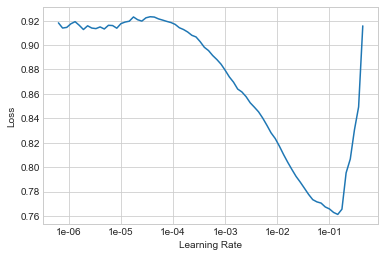

In [26]:
learn.lr_find()
learn.recorder.plot()

In [27]:
learn.fit_one_cycle(4, max_lr=3e-2)

epoch,train_loss,valid_loss,error_rate,time
0,0.408626,0.411563,0.184775,01:41
1,0.381192,0.410575,0.175125,01:42
2,0.368885,0.366989,0.163950,01:41
3,0.355101,0.358766,0.160125,01:42


In [28]:
learn.save('stage-1')

In [10]:
learn.load('stage-1');

In [11]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


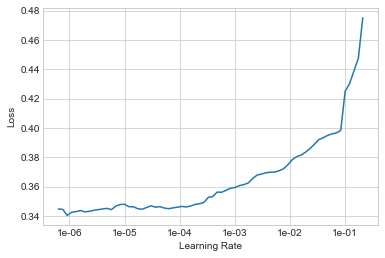

In [33]:
learn.lr_find()
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(4, max_lr=slice(1e-6,3e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.346712,0.359136,0.160100,02:05
1,0.346159,0.359571,0.159475,01:59
2,0.331056,0.361525,0.159425,01:59
3,0.322080,0.362818,0.159275,01:59


In [13]:
learn.save('stage-2')

In [14]:
learn.load('stage-2');

In [15]:
learn.export()

## Interpretation

In [16]:
interp = ClassificationInterpretation.from_learner(learn)

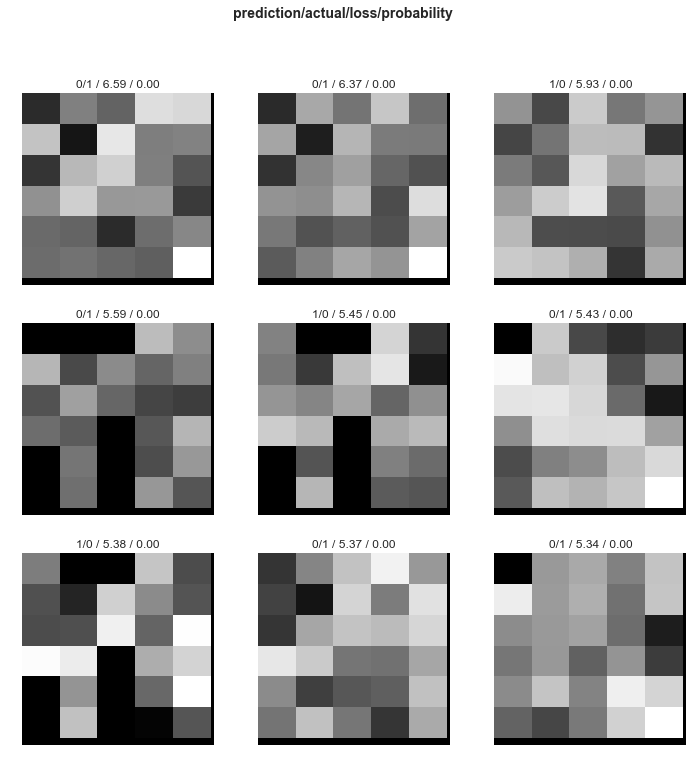

In [17]:
interp.plot_top_losses(9)

### Heatmap
Copied from https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson6-pets-more.ipynb

In [18]:
x,y = data.valid_ds[1]

In [19]:
m = learn.model.eval();

In [20]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [21]:
from fastai.callbacks.hooks import *

In [22]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [23]:
hook_a,hook_g = hooked_backward()

In [24]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([2048, 2, 2])

In [25]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([2, 2])

In [29]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,size,size,0),
              interpolation='bilinear', cmap='magma');

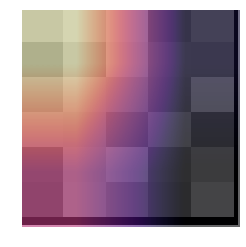

In [30]:
show_heatmap(avg_acts)

### Grad-CAM

In [31]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

(torch.Size([2048, 2, 2]), torch.Size([2048]))

In [32]:
mult = (acts*grad_chan[...,None,None]).mean(0)

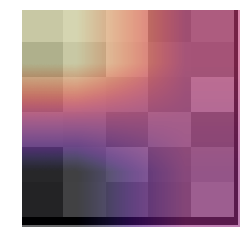

In [33]:
show_heatmap(mult)

# Inference

## Validation

In [34]:
val_df = pd.read_csv(IMG_PATH/'val.csv'); len(val_df); val_df.head()

,image_name,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_lep_pz,PRI_jet_leading_px,PRI_jet_leading_py,PRI_jet_leading_pz,PRI_met_px,PRI_met_py,PRI_met_pt,PRI_jet_num,gen_target,gen_weight
0,0,0,152,122,156,61,77,151,131,79,...,93,138,192,121,130,22,177,170,0,2.706224
1,1,0,243,135,115,228,246,22,57,254,...,123,54,175,13,30,127,202,170,1,0.001503
2,2,63,192,83,118,231,222,17,53,89,...,163,115,153,28,84,62,132,170,0,2.305881
3,3,138,79,142,206,166,131,98,66,78,...,72,123,65,135,170,173,124,170,1,0.001503
4,4,171,224,198,126,0,0,0,126,81,...,110,161,95,106,64,153,137,85,0,2.394896


In [35]:
val_lst = ImageList.from_df(val_df, path, folder='val', suffix='.png')

In [36]:
learn = load_learner(path, test=val_lst)

In [37]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [38]:
val_df['pred'] = to_np(multiclass2binary(preds))

/home/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


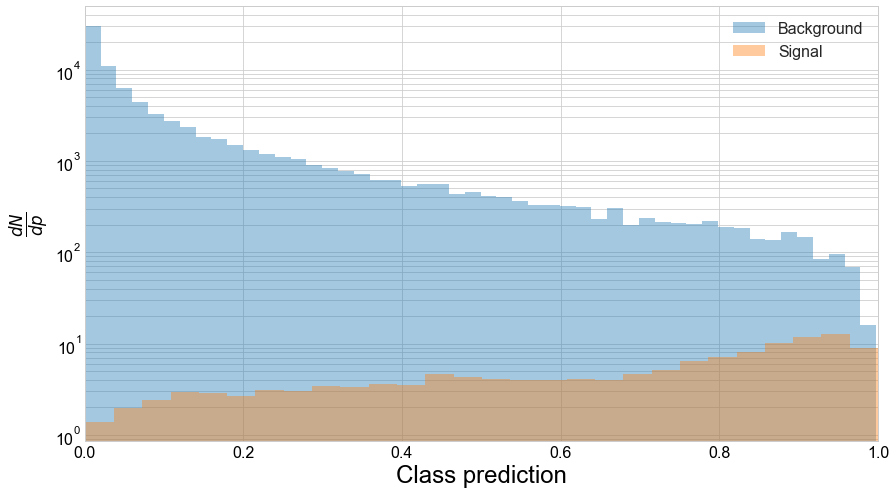

In [39]:
plot_binary_class_pred(val_df, wgt_name='gen_weight', density=False, log_y=True)

Mean cut at 0.8770588040351868 corresponds to AMS of 3.4425182879443788
Maximum AMS for data is 3.6657986389431447 at cut of 0.8444908261299133


/home/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


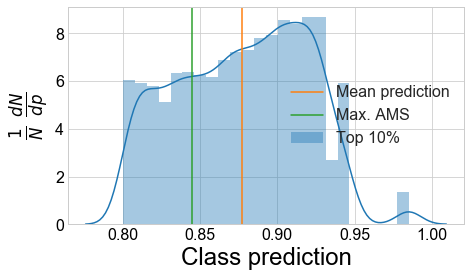

In [40]:
cut, smooth_ams, max_ams = binary_class_cut(val_df, top_perc=10, br=10, wgt_factor=250000/50000, min_pred=0.8)

## Test

In [41]:
test_df = pd.read_csv(IMG_PATH/'test.csv'); len(test_df); test_df.head()

,image_name,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_px,PRI_jet_leading_py,PRI_jet_leading_pz,PRI_met_px,PRI_met_py,PRI_met_pt,PRI_jet_num,gen_target,gen_weight,private
0,0,93,173,116,139,0,0,0,98,146,...,134,171,161,123,56,119,85,0,1.269061,1
1,1,151,212,166,94,0,0,0,147,140,...,0,0,0,74,128,117,0,0,2.782544,1
2,2,0,180,85,74,0,0,0,77,79,...,0,0,0,70,69,143,0,0,2.592303,1
3,3,66,120,80,112,0,0,0,62,85,...,140,150,124,108,103,80,85,0,1.188485,1
4,4,0,197,56,94,0,0,0,28,141,...,0,0,0,37,176,193,0,0,0.994657,1


In [42]:
test_lst = ImageList.from_df(test_df, path, folder='test', suffix='.png')

In [43]:
learn = load_learner(path, test=test_lst)

In [44]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [45]:
test_df['pred'] = to_np(multiclass2binary(preds))

In [46]:
test_df.head()

,image_name,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_py,PRI_jet_leading_pz,PRI_met_px,PRI_met_py,PRI_met_pt,PRI_jet_num,gen_target,gen_weight,private,pred
0,0,93,173,116,139,0,0,0,98,146,...,171,161,123,56,119,85,0,1.269061,1,0.014302
1,1,151,212,166,94,0,0,0,147,140,...,0,0,74,128,117,0,0,2.782544,1,0.105622
2,2,0,180,85,74,0,0,0,77,79,...,0,0,70,69,143,0,0,2.592303,1,0.022968
3,3,66,120,80,112,0,0,0,62,85,...,150,124,108,103,80,85,0,1.188485,1,0.017565
4,4,0,197,56,94,0,0,0,28,141,...,0,0,37,176,193,0,0,0.994657,1,0.015223


In [47]:
score_test_df(test_df, cut)

Public:Private AMS: 3.302631391744321 : 3.4092835567142585


(3.302631391744321, 3.4092835567142585)

In [48]:
score_test_df(test_df, 0.8444908261299133)

Public:Private AMS: 3.402578974614776 : 3.4793688283469066


(3.402578974614776, 3.4793688283469066)

In [62]:
from lumin.evaluation.ams import *
from sklearn.model_selection import StratifiedKFold, KFold

In [63]:
ams_scan_quick(test_df[test_df.private==0], br=10), ams_scan_quick(test_df[test_df.private==1], br=10)

((3.445078413428615, 0.827568769454956),
 (3.4852542049401114, 0.8251104354858398))

In [67]:
def subsample_score_test(df:pd.DataFrame, cut:Optional[float]=None):
    amss = pd.DataFrame(columns=['Public_AMS', 'Private_AMS', 'Public_Cut', 'Private_Cut'])
    skf = StratifiedKFold(10, True)
    folds = skf.split(df, df.private)
    for _, fold in folds:
        test_fold = test_df.iloc[fold]
        if cut is None:
            public_ams, public_cut = ams_scan_quick(test_fold[test_fold.private==0], br=10, wgt_factor=len(test_df[test_df.private==0])/len(test_fold[test_fold.private==0]))
            private_ams, private_cut = ams_scan_quick(test_fold[test_fold.private==1], br=10, wgt_factor=len(test_df[test_df.private==1])/len(test_fold[test_fold.private==1]))
        else:
            public_cut,private_cut = cut,cut 
            public_ams, private_ams = score_test_df(test_fold, cut, verbose=False,
                                                    public_wgt_factor=len(test_df[test_df.private==0])/len(test_fold[test_fold.private==0]),
                                                    private_wgt_factor=len(test_df[test_df.private==1])/len(test_fold[test_fold.private==1]))
        amss = amss.append({'Public_AMS':public_ams, 'Private_AMS':private_ams, 'Public_Cut':public_cut, 'Private_Cut':private_cut}, ignore_index=True)
    return amss

In [68]:
results = subsample_score_test(test_df); results

,Public_AMS,Private_AMS,Public_Cut,Private_Cut
0,4.185327,3.426568,0.982880,0.856758
1,3.530971,3.441027,0.762952,0.862281
2,3.425730,3.383180,0.850051,0.838330
3,3.609690,3.584343,0.914457,0.915697
4,4.420234,3.648307,0.973780,0.793706
5,3.804523,3.643584,0.873382,0.892176
6,3.562903,3.645513,0.815318,0.821842
7,3.617899,3.679857,0.891103,0.863581
8,3.453281,3.417403,0.988063,0.823442
9,5.433634,3.616959,0.983105,0.835231


In [69]:
results.describe()

,Public_AMS,Private_AMS,Public_Cut,Private_Cut
count,10.000000,10.000000,10.000000,10.000000
mean,3.904419,3.548674,0.903509,0.850305
std,0.628152,0.116702,0.079089,0.035740
min,3.425730,3.383180,0.762952,0.793706
25%,3.538954,3.430183,0.855884,0.826389
50%,3.613795,3.600651,0.902780,0.847544
75%,4.090126,3.645030,0.980605,0.863256
max,5.433634,3.679857,0.988063,0.915697


In [70]:
results = subsample_score_test(test_df, cut=0.8444908261299133); results

,Public_AMS,Private_AMS,Public_Cut,Private_Cut
0,3.635310,3.372974,0.844491,0.844491
1,3.215301,3.602101,0.844491,0.844491
2,3.414928,3.566252,0.844491,0.844491
3,3.559950,3.526577,0.844491,0.844491
4,3.534626,3.339742,0.844491,0.844491
5,3.200468,3.682278,0.844491,0.844491
6,3.726009,3.388004,0.844491,0.844491
7,3.265974,3.301976,0.844491,0.844491
8,3.159471,3.559463,0.844491,0.844491
9,3.456459,3.490638,0.844491,0.844491


In [71]:
results.describe()

,Public_AMS,Private_AMS,Public_Cut,Private_Cut
count,10.000000,10.000000,10.000000,10.000000
mean,3.416849,3.483001,0.844491,0.844491
std,0.198795,0.126075,0.000000,0.000000
min,3.159471,3.301976,0.844491,0.844491
25%,3.227969,3.376731,0.844491,0.844491
50%,3.435693,3.508607,0.844491,0.844491
75%,3.553619,3.564554,0.844491,0.844491
max,3.726009,3.682278,0.844491,0.844491
